In [9]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import random
from IPython.display import clear_output
from collections import deque, namedtuple
from tqdm.notebook import tqdm
from collections import deque
from typing import Any, List, Tuple

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras.backend as K

tf.compat.v1.disable_eager_execution()

# Experience Replay

### Overview

Experience Replay is a widely adopted technique in Reinforcement Learning (RL) aimed at enhancing both the efficiency and stability of the learning process. It involves storing past experiences, typically in the form of state-action-reward sequences, and reusing this data during training. By leveraging these past experiences, the agent can learn more effectively, reduce correlation between consecutive updates, and improve overall performance.

### Implementation

For the implementation, it is suggested to using Sum Tree structure for efficiency. 
A Sum Tree is a binary tree where:

- Leaf Nodes: Store the actual priorities of the transitions.
- Internal Nodes: Store the sum of their child nodes' priorities.

This structure allows:

- Efficient Sampling: Sampling a transition proportional to its priority can be done in $O(logN)$ time, where N is the number of transitions.
- Efficient Updates: Updating a transition's priority also takes $O(logN)$ time.

In [10]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class SumTree:
    """
    This SumTree structure stores priorities and allows for efficient sampling and updating.
        0
       / \
      0   0
     / \ / \
    0  0 0  0 
    """
    def __init__(self, capacity):
        """
        Initialize the SumTree with a given capacity.
        
        Args:
            capacity (int): Number of leaf nodes (i.e., maximum number of transitions).
        """
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)  # To store transitions
        self.write = 0
        self.n_entries = 0

    def _propagate(self, idx, change):
        """
        Propagate the change up the tree.
        
        Args:
            idx (int): Index of the leaf node.
            change (float): Change in priority.
        """
        parent = (idx - 1) // 2
        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        """
        Find the leaf node corresponding to the sampled value s.
        
        Args:
            idx (int): Current tree index.
            s (float): Sampled value.
        
        Returns:
            int: Index of the leaf node.
        """
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total_priority(self):
        """
        Get the total priority (value of the root node).
        
        Returns:
            float: Total priority.
        """
        return self.tree[0]

    def add(self, priority, data):
        """
        Add a new transition with its priority.
        
        Args:
            priority (float): Priority of the transition.
            data (object): The transition data.
        """
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, priority)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0  # Overwrite when capacity is reached

        if self.n_entries < self.capacity:
            self.n_entries += 1

    def update(self, idx, priority):
        """
        Update the priority of an existing transition.
        
        Args:
            idx (int): Index of the leaf node.
            priority (float): New priority value.
        """
        change = priority - self.tree[idx]
        self.tree[idx] = priority
        self._propagate(idx, change)

    def get(self, s):
        """
        Get a transition based on the sampled value s.
        
        Args:
            s (float): Sampled value.
        
        Returns:
            (int, float, object): Tuple containing the index, priority, and transition data.
        """
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[data_idx])

    def __len__(self):
        return self.n_entries

class Memory:
    """
    Memory class that uses SumTree to store experiences 
    """
    def __init__(
            self,
            capacity,
            alpha = 0.6,
            beta = 0.4,
            beta_increment = 0.001,
            epsilon = 0.01,
            abs_upper_err = 1.0
    ):
        
        self.tree = SumTree(capacity=capacity)
        self.alpha = alpha
        self.beta = beta 
        self.beta_increment = beta_increment
        self.epsilon = epsilon
        self.abs_err_upper = abs_upper_err

    def store(self, transition: Transition):
        max_p = np.max(self.tree.tree[-self.tree.capacity:])
        if max_p == 0:
            max_p = self.abs_err_upper
        self.tree.add(max_p,transition)

    def sample(self, n) -> Tuple[np.ndarray, List[Transition], np.ndarray]:
        b_idx = np.empty((n,), dtype= np.int32)
        b_memory: List[Transition] = []
        ISweight = np.empty((n,1), dtype=np.float32)
        pri_seg = self.tree.total_priority()/ n
        self.beta = min(1.0, self.beta + self.beta_increment)

        # Find the minimum probability to normalize IS weight
        leaf_priorities = self.tree.tree[-self.tree.capacity:]
        min_p = np.min(leaf_priorities) / self.tree.total_priority()
        if min_p == 0:
            min_p = self.epsilon

        for i in range(n):
            a, b = pri_seg * i , pri_seg * (i+1)
            v = np.random.uniform(a,b)
            idx, p, data = self.tree.get(v)
            prob = p / self.tree.total_priority()
            ISweight[i, 0] = np.power(prob / min_p, -self.beta)
            b_idx[i] = idx
            b_memory.append(data)

        return b_idx, b_memory, ISweight
    
    def batch_update(self, tree_idx: List[int], abs_errors: np.ndarray):
        """
        Update priorities for sample 
        """

        abs_errors += self.epsilon
        clipped_errors = np.minimum(abs_errors, self.abs_err_upper)
        ps = np.power(clipped_errors, self.alpha)

        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti,p)

    def __len__(self):
        return len(self.tree)    


In [ ]:
class DQAgent_Buffer:
    def __init__(self,
                 observation_space,
                 action_space,
                 gamma = 0.99,
                 lr = 0.001,
                 capacity = 50000,
                 alpha = 0.6,
                 beta = 0.4, 
                 beta_increment = 0.001,
                 epsilon = 1.0,
                 epsilon_decay = 0.9995,
                 epsilon_min= 0.01,
                 abs_err_upper = 1.0):
        
        self.observation_space = observation_space
        self.action_space = action_space
        self.gamma = gamma
        self.lr = lr
        self.alpha = alpha
        self.beta = beta 
        self.beta_increment = beta_increment
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.abs_err_upper = abs_err_upper

        self.memory = Memory(capacity=capacity)

        self.model = self.build_model(name = "model")
        self.target_model = self.build_model(name = "target")
        self.update_target()

    def remember(self, state, action, reward, next_state, done):
        transition = Transition(state, action, reward, next_state, done)
        self.memory.store(transition)

    def build_model(self, name):
        model = keras.Sequential(name=name)
        model.add(layers.Input(shape=self.observation_space))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(self.action_space, activation='linear'))

        optimizer = keras.optimizers.Adam(learning_rate=self.lr, clipvalue=1.0) 
        model.compile(
            optimizer=optimizer,
            loss='mse'
        )
        return model
    
    def update_target(self):
        self.target_model.set_weights(self.model.get_weights())

    def predict(self, observation, target = False):
        if target:
            return self.target_model.predict(np.array([observation]), verbose=False)[0]
        return self.model.predict(np.array([observation]), verbose=False)[0]
    
    def predict_action(self, observation):
        return np.argmax(self.predict(observation))
    
    def e_greedy(self, observation):
        if random.random() >= self.epsilon:
            return self.predict_action(observation)
        return random.randint(0, self.action_space - 1)
    
    def train(self, batch_size):
        if len(self.memory) < batch_size:
            return

        # Sample a batch from memory
        tree_idx, batch, ISWeights = self.memory.sample(batch_size)

        # Extract elements from the batch
        states = np.array([transition.state for transition in batch])
        actions = np.array([transition.action for transition in batch])
        rewards = np.array([transition.reward for transition in batch])
        next_states = np.array([transition.next_state for transition in batch])
        dones = np.array([transition.done for transition in batch])

        # Predict Q-values for current states and next states using target network
        Q_values = self.model.predict(states, verbose=False)
        Q_next = self.target_model.predict(next_states, verbose=False)
        max_Q_next = np.max(Q_next, axis=1)

        # Compute target Q-values
        targets = Q_values.copy()
        targets[np.arange(batch_size), actions] = rewards + self.gamma * max_Q_next * (1 - dones)

        # Compute TD errors for updating priorities
        td_errors = np.abs(targets[np.arange(batch_size), actions] - Q_values[np.arange(batch_size), actions])

        # Update priorities in memory
        self.memory.batch_update(tree_idx, td_errors)

        # Train the model with importance sampling weights
        self.model.fit(states, targets, sample_weight=ISWeights.flatten(), epochs=1, verbose=False)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [12]:
env = gym.make("LunarLander-v2")
agent = DQAgent_Buffer(env.observation_space.shape, env.action_space.n)

episodes = 1000
max_t = 500
scores = []
avgs = []
count = 0

for episode in range(episodes):
    observation, _ = env.reset()
    
    score = 0
    for t in range(max_t):
        count += 1
        s = observation
        a = agent.e_greedy(s)
        observation, reward, terminated, _, _ = env.step(a)
        score +=  reward
        s_ = observation
        agent.remember(s, a, reward, s_, terminated)
        agent.train(32)

        if count % 400 == 0:
            agent.update_target()
        
        if terminated:
            break
    scores.append(score)
    avgs.append(np.sum(scores[-50:])/len(scores[-50:]))
    print(f"episode: {episode}, e: {agent.epsilon}, t: {t}, score: {score : .2f}, avg score: {avgs[-1]: .2f}")
    if avgs[-1] >= 200:
        break

c:\Users\admin\anaconda3\envs\test\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Users\admin\anaconda3\envs\test\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


episode: 0, e: 0.974816162420625, t: 81, score: -110.67, avg score: -110.67
episode: 1, e: 0.9300488837502441, t: 93, score: -253.00, avg score: -181.84
episode: 2, e: 0.876312066660663, t: 118, score: -133.59, avg score: -165.76
episode: 3, e: 0.8294049478673904, t: 109, score: -107.91, avg score: -151.29
episode: 4, e: 0.781092443499295, t: 119, score: -160.75, avg score: -153.19
episode: 5, e: 0.7381738593872831, t: 112, score: -184.41, avg score: -158.39
episode: 6, e: 0.7081592517292976, t: 82, score: -46.19, avg score: -142.36
episode: 7, e: 0.6576352813905723, t: 147, score: -242.25, avg score: -154.85
episode: 8, e: 0.6162386076621498, t: 129, score: -150.45, avg score: -154.36
episode: 9, e: 0.571414780905264, t: 150, score: -89.77, avg score: -147.90
episode: 10, e: 0.5365177262619544, t: 125, score: -155.00, avg score: -148.55
episode: 11, e: 0.5085615358533134, t: 106, score: -114.53, avg score: -145.71
episode: 12, e: 0.47322370058897834, t: 143, score: -77.01, avg score: 

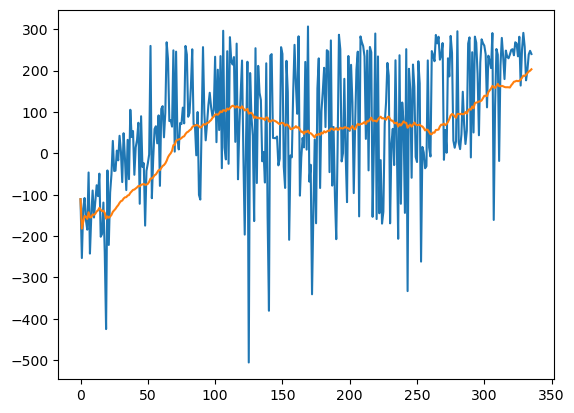

In [13]:
plt.plot(scores)
plt.plot(avgs)
plt.show()